In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from scipy import sparse
import pickle as pk
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#loading BoW 
train_bow=sparse.load_npz("train_bow.npz")
#cv_bow=sparse.load_npz("cv_bow.npz")
test_bow=sparse.load_npz("test_bow.npz")
traincv_bow=sparse.load_npz("traincv_bow.npz")

In [3]:
#loading tf-idf data
train_tfidf=sparse.load_npz("train_tfidf.npz")
#cv_tfidf=sparse.load_npz("cv_fidf.npz")
traincv_tfidf=sparse.load_npz("traincv_tfidf.npz")
test_tfidf=sparse.load_npz("test_tfidf.npz")

In [4]:
#loading word2vec
with open('train_w2v.pkl', 'rb') as tr:
    train_w2v = pk.load(tr)
#with open('cv_w2v.pkl','rb') as cvl:
    #cv_w2v = pk.load(cvl)
with open('train_w2v.pkl','rb') as tcv:
     traincv_w2v=pk.load(tcv)
with open('test_w2v.pkl','rb') as tst:
    test_w2v=pk.load(tst)

In [5]:
#loading tfidf weighted w2v
with open('train_tfidf_w2v.pkl', 'rb') as t:
    train_tfidf_w2v = pk.load(t)
with open('cv_tfidf_w2v.pkl','rb') as c:
    cv_tfidf_w2v=pk.load(c)
with open('traincv_tfidf_w2v.pkl','rb') as tcv:
    traincv_tfidf_w2v=pk.load(tcv)
with open('test_tfidf_w2v.pkl','rb') as ts:
    test_tfidf_w2v=pk.load(ts)    


In [6]:
train=pd.read_csv('train')
cv=pd.read_csv('cv')
test=pd.read_csv('test')
traincv=pd.read_csv('traincv')
train_y=train['Score']
cv_y=cv['Score']
traincv_y=traincv['Score']
test_y=test['Score']

In [39]:
def logreg_grid(train,y_train):
    logreg = LogisticRegression()
    param_grid = {'C':[50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],
             'penalty':['l1','l2']} 
    tscv = TimeSeriesSplit(n_splits=3) #For time based splitting
    gscv = GridSearchCV(logreg,param_grid,cv=tscv,verbose=1) 
    gscv.fit(train,y_train)
    print("Best HyperParameter: ",gscv.best_params_)
    print("Best Accuracy is: %.2f%%"%(gscv.best_score_*100))
    pl=gscv.cv_results_['param_penalty']
    sc=gscv.cv_results_['mean_test_score']
    c=gscv.cv_results_['param_C']
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for i in range(len(pl)):
        if pl[i]=='l1':
            y1.append(1-sc[i])
            x1.append(c[i])
        else:
            y2.append(1-sc[i])
            x2.append(c[i])
    plt.xlim(-10,100)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title(' Error v/s C')
    plt.plot(x1,y1,'g',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()          

In [8]:
def logreg_random(train,train_y):
    lr = LogisticRegression()
    param_grid = {'C':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001],'penalty':['l1','l2']} 
    tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
    gscv = RandomizedSearchCV(lr,param_grid,cv=tscv,verbose=1) 
    gscv.fit(train,train_y)
    print("Best HyperParameter: ",gscv.best_params_)
    print("Best Accuracy: %.2f%%"%(gscv.best_score_*100))
    pl=gscv.cv_results_['param_penalty']
    sc=gscv.cv_results_['mean_test_score']
    c=gscv.cv_results_['param_C']
    x1=[]
    y1=[]
    x2=[]
    y2=[]
    for i in range(len(pl)):
        if pl[i]=='l1':
            y1.append(1-sc[i])
            x1.append(c[i])
        else:
            y2.append(1-sc[i])
            x2.append(c[i])
    plt.xlim(-10,100)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title(' Error v/s C')
    plt.plot(x1,y1,'g',label="L1")
    plt.plot(x2,y2,'r',label="L2")
    plt.legend()
    plt.show()          

In [9]:
def test_logreg(train_data,train_y,test_data,test_y,i,j):
    lr = LogisticRegression(C=i,penalty=j)
    lr.fit(train_data,train_y)
    pred = lr.predict(test_data)
    print("Precision on test set: %0.3f"%(precision_score(test_y,pred)))
    print("Recall on test set: %0.3f"%(recall_score(test_y,pred)))
    print("F1-Score on test set: %0.3f"%(f1_score(test_y,pred)))
    print("Non Zero weights:",np.count_nonzero(lr.coef_))
    df_cm = pd.DataFrame(confusion_matrix(test_y,pred), range(2),range(2))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

In [10]:
def sparsity_increase(train_data,train_y,test_data,test_y):
    C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
    l1_value = ['l1','l1','l1','l1','l1','l1','l1','l1']
    for i,j in zip(C_value[-10:],l1_value[-8:]):
        lr = LogisticRegression(C=i,penalty=j)
        lr.fit(train_data,train_y)
        pred = lr.predict(test_data)
        print("C_value and l1_value=",i,j)
        print("roc_auc score on test set: %0.3f%%"%(roc_auc_score(test_y,pred)*100))
        print("Non Zero weights:",np.count_nonzero(lr.coef_))
        print("-"*100)


#for i,j in zip(C_value,l1_value):
   # sparsity_increase(i,j)

# Pertubation Test

In [11]:
logreg = LogisticRegression(C= 10, penalty= 'l2')
logreg.fit(traincv_bow,traincv_y)
pred = logreg.predict(test_bow)
print("F-1 Score on test set: %0.3f%%"%(f1_score(test_y, pred)*100))
print("Non Zero weights:",np.count_nonzero(logreg.coef_))

F-1 Score on test set: 94.975%
Non Zero weights: 24873


In [12]:
from scipy.sparse import find
#Weights before adding random noise
weights1 = find(logreg.coef_[0])[2]

In [13]:
traincv_noise = traincv_bow
#Random noise
epsilon = np.random.uniform(low=-0.0001, high=0.0001, size=(find(traincv_noise)[0].size,))
#Getting the postions(row and column) and value of non-zero datapoints 
a,b,c = find(traincv_noise)

#Introducing random noise to non-zero datapoints
traincv_noise[a,b] = epsilon + traincv_noise[a,b]

In [14]:
logreg_n = LogisticRegression(C= 10, penalty= 'l2')
logreg_n.fit(traincv_noise,traincv_y)
pred = logreg_n.predict(test_bow)
print("F-1 Score on test set: %0.3f%%"%(f1_score(test_y, pred)*100))
print("Non Zero weights:",np.count_nonzero(logreg_n.coef_))

F-1 Score on test set: 94.975%
Non Zero weights: 24873


In [15]:
from scipy.sparse import find
#Weights after adding random noise
weights_n = find(logreg_n.coef_[0])[2]

In [16]:
weights_diff = (abs(weights1 - weights_n)/weights1) * 100

In [17]:
print(weights_diff[np.where(weights_diff > 30)].size)

4


# Logistic Reggression on BoW 

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
traincv_bow=bow.fit_transform(traincv['CleanedText'])

In [19]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bow,logreg)

			Positive						Negative
________________________________________________________________________________________________
	-13.5147	udo            				10.8867	cutest         
	-11.1315	atmospher      				9.6747	ad             
	-9.5858	delic          				9.3135	elf            
	-9.2146	ude            				8.8903	attack         
	-9.1758	studi          				8.8272	obes           
	-9.1466	spay           				8.5198	enzym          
	-8.9107	halakh         				8.3157	beefi          
	-8.7851	squeez         				7.8614	runnier        
	-8.4487	biafra         				7.8505	unhealthi      
	-8.0008	demens         				7.7245	bariatr        
	-7.8517	burnout        				7.5606	alterant       
	-7.8404	isopropyl      				7.4620	garten         
	-7.7331	teeccino       				7.3345	hackjob        
	-7.5969	solarfest      				7.2989	talisman       
	-7.2592	price          				7.1804	ramon          
	-7.0326	ftw            				6.7858	barn           
	-6.9992	tag            				6.7437	enflora        
	-6.738

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 20.6min finished


Best HyperParameter:  {'C': 0.5, 'penalty': 'l2'}
Best Accuracy is: 90.46%


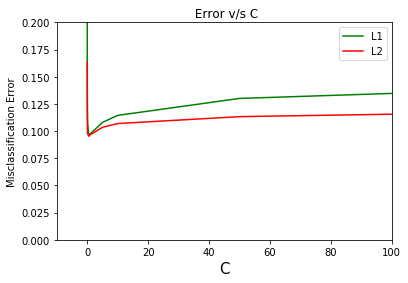

In [21]:
logreg_grid(traincv_bow,traincv_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 31.7min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 0.5}
Best Accuracy: 90.59%


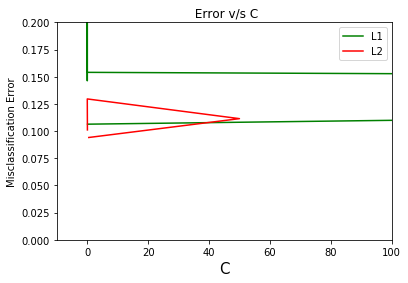

In [22]:
logreg_random(traincv_bow,traincv_y)

Precision on test set: 0.905
Recall on test set: 0.985
F1-Score on test set: 0.943
Non Zero weights: 24873


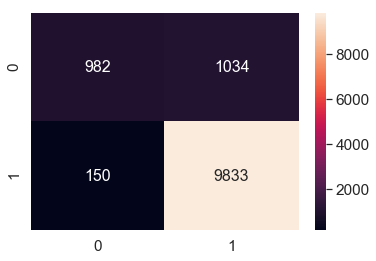

In [25]:
c=0.5
pen='l2'
test_logreg(train_bow,train_y,test_bow,test_y,c,pen)

In [27]:
sparsity_increase(train_bow,train_y,test_bow,test_y)

C_value and l1_value= 1000 l1
roc_auc score on test set: 74.466%
Non Zero weights: 8493
----------------------------------------------------------------------------------------------------
C_value and l1_value= 100 l1
roc_auc score on test set: 77.302%
Non Zero weights: 7439
----------------------------------------------------------------------------------------------------
C_value and l1_value= 10 l1
roc_auc score on test set: 80.536%
Non Zero weights: 4055
----------------------------------------------------------------------------------------------------
C_value and l1_value= 1 l1
roc_auc score on test set: 78.256%
Non Zero weights: 802
----------------------------------------------------------------------------------------------------
C_value and l1_value= 0.1 l1
roc_auc score on test set: 64.103%
Non Zero weights: 128
----------------------------------------------------------------------------------------------------
C_value and l1_value= 0.01 l1
roc_auc score on test set: 50.000%

# Logistic Reggression on Tf-Idf

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 20.9min finished


Best HyperParameter:  {'C': 10, 'penalty': 'l2'}
Best Accuracy is: 90.51%


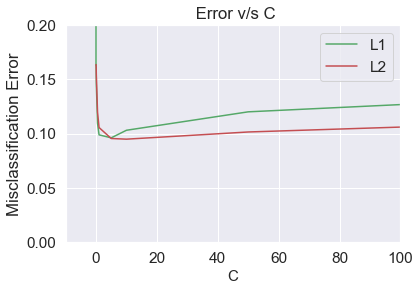

In [110]:
logreg_grid(traincv_tfidf,traincv_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.4min finished


Best HyperParameter:  {'penalty': 'l1', 'C': 1}
Best Accuracy: 90.15%


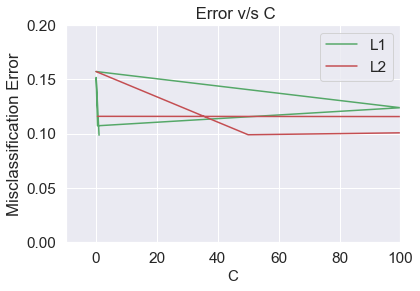

In [111]:
logreg_random(traincv_tfidf,traincv_y)

Precision on test set: 0.929
Recall on test set: 0.968
F1-Score on test set: 0.948
Non Zero weights: 24873


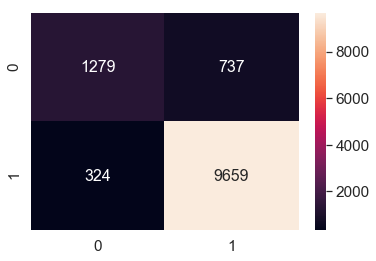

In [112]:
c=10
pen='l2'
test_logreg(traincv_tfidf,traincv_y,test_tfidf,test_y,c,pen)

Precision on test set: 0.924
Recall on test set: 0.973
F1-Score on test set: 0.948
Non Zero weights: 1096


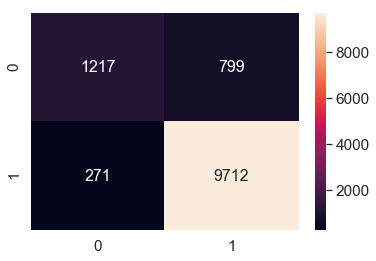

In [113]:
c=1
pen='l1'
test_logreg(traincv_tfidf,traincv_y,test_tfidf,test_y,c,pen)

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
transformed = vectorizer.fit_transform(traincv['CleanedText'])
print("Num words:",len(vectorizer.get_feature_names()))
feat=vectorizer.get_feature_names()

Num words: 26699


In [136]:
logreg=LogisticRegression(C=10,penalty='l2')
logr=logreg.fit(traincv_tfidf,traincv_y)

In [137]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(feat,logr)

			Positive						Negative
________________________________________________________________________________________________
	-12.0359	udo            				14.7068	garten         
	-10.8123	delic          				14.4618	cutest         
	-9.8671	atmospher      				12.7069	beefi          
	-8.0914	spay           				11.0208	obes           
	-8.0205	ude            				10.7753	elf            
	-7.8539	halakh         				9.8226	kitschi        
	-7.6573	studi          				9.3078	ad             
	-7.6088	squeez         				8.8297	attack         
	-7.5072	isopropyl      				8.4254	runnier        
	-7.2287	biafra         				8.3913	enzym          
	-7.1381	teeccino       				7.4281	alterant       
	-7.0304	demens         				7.3518	unhealthi      
	-6.9744	price          				7.1264	bariatr        
	-6.4964	burnout        				7.0269	ramon          
	-6.4297	solarfest      				6.7733	twain          
	-6.3072	tag            				6.7281	hackjob        
	-6.1331	syring         				6.5696	cvs            
	-6

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished


Best HyperParameter:  {'penalty': 'l2', 'C': 50}
Best Accuracy: 87.87%


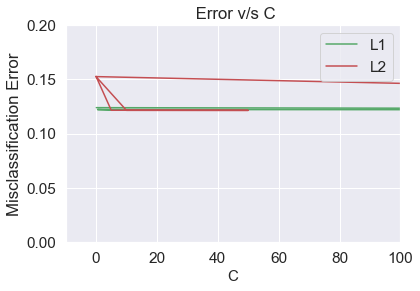

In [141]:
logreg_random(traincv_w2v,train_y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.0min finished


Best HyperParameter:  {'C': 5, 'penalty': 'l2'}
Best Accuracy is: 87.50%


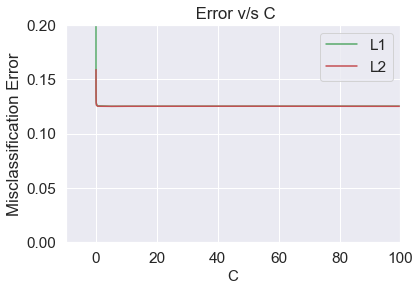

In [31]:
logreg_grid(traincv_w2v,train_y)

Precision on test set: 0.889
Recall on test set: 0.965
F1-Score on test set: 0.926
Non Zero weights: 50


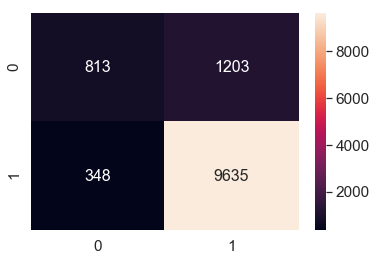

In [34]:
c=5
pen='l2'
test_logreg(train_w2v,train_y,test_w2v,test_y,c,pen)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   23.4s finished


Best HyperParameter:  {'C': 50, 'penalty': 'l1'}
Best Accuracy is: 84.68%


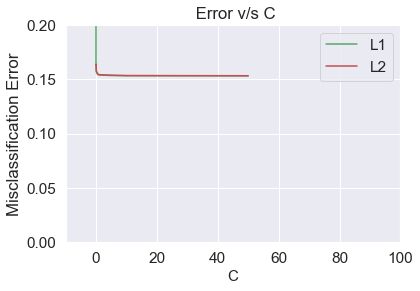

In [40]:
logreg_grid(traincv_tfidf_w2v,traincv_y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.1s finished


Best HyperParameter:  {'penalty': 'l1', 'C': 5}
Best Accuracy: 85.35%


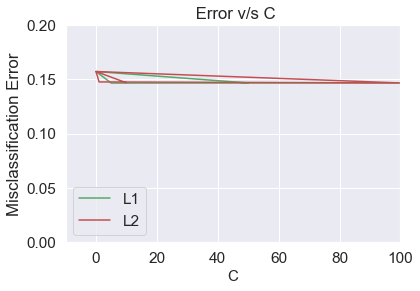

In [41]:
logreg_random(traincv_tfidf_w2v,traincv_y)

Precision on test set: 0.838
Recall on test set: 0.962
F1-Score on test set: 0.895
Non Zero weights: 50


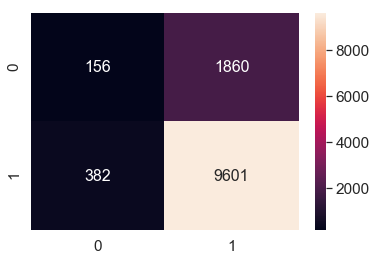

In [42]:
c=5
pen='l1'
test_logreg(traincv_tfidf_w2v,traincv_y,test_tfidf_w2v,test_y,c,pen)